In [2]:
#import pandas as pd

#df = pd.read_json("dblp-ref-0.json", lines=True)

#df_clean = df.dropna()
#df_clean = df_clean[~df_clean.eq("NaN").any(axis=1)]
#df_clean = df_clean[df_clean["authors"].str.len() > 0]
#df_clean = df_clean[df_clean["references"].str.len() > 0]

#print(df.shape[0])
#print(df_clean.shape[0])


### Dataset stats before removing invalid data

In [3]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from io import StringIO

# --------------------------------------------
# Rules
# --------------------------------------------
# strings with a hyphen and then a space are invalid
HYPH_REGEX = r"[A-Za-z]-\s+[A-Za-z]"
hyphenation_re = re.compile(HYPH_REGEX)


# --------------------------------------------
# Chunked reader for JSONL
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                json_text = "[{}]".format(",".join(batch))
                yield pd.read_json(StringIO(json_text))
                batch = []
        if batch:
            json_text = "[{}]".format(",".join(batch))
            yield pd.read_json(StringIO(json_text))


# --------------------------------------------
# Fast profiling for each chunk
# --------------------------------------------
def profile_chunk(df, seen_ids, seen_rows_hashes):
    stats = defaultdict(int)

    # ----------------------------------------
    # EMPTY FIELDS
    # ----------------------------------------
    if "authors" in df:
        stats["empty_authors"] += df["authors"].map(lambda x: len(x) == 0 if isinstance(x, list) else False).sum()

    if "references" in df:
        stats["empty_references"] += df["references"].map(lambda x: len(x) == 0 if isinstance(x, list) else False).sum()

    for col in ["title", "venue", "abstract"]:
        if col in df:
            stats[f"empty_{col}"] += (
                df[col].isna() |
                df[col].eq("") |
                df[col].eq("NaN")
            ).sum()

    for col in ["year", "n_citation"]:
        if col in df:
            stats[f"empty_{col}"] += df[col].isna().sum()

    # ----------------------------------------
    # HYPHENATION
    # ----------------------------------------
    for col in ["title", "venue", "abstract"]:
        if col in df:
            stats[f"hyph_{col}"] += df[col].str.contains(HYPH_REGEX, regex=True, na=False).sum()

    # ----------------------------------------
    # GLOBAL DUPLICATE IDS
    # ----------------------------------------
    if "id" in df:
        for val in df["id"].astype(str):
            if val in seen_ids:
                stats["duplicate_ids"] += 1
            else:
                seen_ids.add(val)

    # ----------------------------------------
    # GLOBAL DUPLICATE ROWS
    # ----------------------------------------
    df_for_dupes = df.copy()

    # convert lists → strings only where necessary
    for col in df_for_dupes.columns:
        if df_for_dupes[col].apply(lambda x: isinstance(x, list)).any():
            df_for_dupes[col] = df_for_dupes[col].astype(str)

    # compute hashes for full rows to detect duplicates across chunks
    row_hashes = df_for_dupes.astype(str).agg('|'.join, axis=1)

    for h in row_hashes:
        if h in seen_rows_hashes:
            stats["duplicate_rows"] += 1
        else:
            seen_rows_hashes.add(h)

    # row count
    stats["rows"] += len(df)

    return stats


# --------------------------------------------
# Profile entire file
# --------------------------------------------
def profile_file(path):
    totals = defaultdict(int)
    seen_ids = set()
    seen_rows_hashes = set()

    for chunk in read_jsonl_chunks(path):
        chunk_stats = profile_chunk(chunk, seen_ids, seen_rows_hashes)
        for k, v in chunk_stats.items():
            totals[k] += v

    return totals


# --------------------------------------------
# Summary for multiple files
# --------------------------------------------
def profile_files(jsonl_files):
    report_rows = []

    for file in jsonl_files:
        print(f"Processing {file} ...")

        totals = profile_file(file)

        row = {
            "file": file,
            "rows_total": totals["rows"],
            "duplicate_rows": totals["duplicate_rows"],
            "duplicate_ids": totals["duplicate_ids"],
        }

        # Add empty/hyphen fields
        for col in ["authors", "references", "title", "venue", "abstract", "year", "n_citation"]:
            row[f"empty_{col}"] = totals.get(f"empty_{col}", 0)
            row[f"hyphen_{col}"] = totals.get(f"hyph_{col}", 0)

        report_rows.append(row)

    return pd.DataFrame(report_rows)


# --------------------------------------------
# Run
# --------------------------------------------
files = [
    "dblp-ref-0.json",
    "dblp-ref-1.json",
    "dblp-ref-2.json",
    "dblp-ref-3.json"
]

summary_report = profile_files(files)
print(summary_report)
#summary_report.to_csv("dataset_quality_report.csv", index=False)

Processing dblp-ref-0.json ...


KeyboardInterrupt: 

## Clean dataset of invalid data

In [4]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from io import StringIO
import json

# Required fields
REQUIRED_LIST_FIELDS = ["authors", "references"]
REQUIRED_STR_FIELDS = ["title", "venue", "abstract"]  # abstract optional

HYPH_REGEX = r"[A-Za-z]-\s+[A-Za-z]"

# --------------------------------------------
# Chunked JSONL reader
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                json_text = "[{}]".format(",".join(batch))
                yield pd.read_json(StringIO(json_text))
                batch = []
        if batch:
            json_text = "[{}]".format(",".join(batch))
            yield pd.read_json(StringIO(json_text))

# --------------------------------------------
# Hyphenation check
# --------------------------------------------
def has_bad_hyphenation(series):
    return series.str.contains(HYPH_REGEX, regex=True, na=False)

# --------------------------------------------
# Clean a single chunk
# --------------------------------------------
def clean_chunk(df, seen_ids):
    # Remove empty required list fields
    for col in REQUIRED_LIST_FIELDS:
        if col in df:
            df = df[df[col].map(lambda x: isinstance(x, list) and len(x) > 0)]
    
    # Remove empty required string fields
    for col in REQUIRED_STR_FIELDS:
        if col in df:
            df = df[~df[col].isna()]
            df = df[~df[col].eq("") & ~df[col].eq("NaN")]

    # Remove hyphenation issues
    for col in REQUIRED_STR_FIELDS:
        if col in df:
            df = df[~has_bad_hyphenation(df[col])]

    # Remove duplicate IDs across all chunks/files
    if "id" in df:
        df = df[~df["id"].astype(str).isin(seen_ids)]
        seen_ids.update(df["id"].astype(str).tolist())

    return df

# --------------------------------------------
# Clean multiple files into a single output file
# --------------------------------------------
def clean_files_to_one(input_files, output_file):
    seen_ids = set()

    with open(output_file, "w", encoding="utf-8") as fout:
        for input_path in input_files:
            print(f"Processing {input_path} ...")
            for chunk in read_jsonl_chunks(input_path):
                cleaned_chunk = clean_chunk(chunk, seen_ids)
                if len(cleaned_chunk) == 0:
                    continue
                # Write cleaned records to the single output file
                for record in cleaned_chunk.to_dict(orient="records"):
                    fout.write(json.dumps(record) + "\n")

# --------------------------------------------
# Run cleaning
# --------------------------------------------
input_files = [
    "dblp-ref-0.json",
    "dblp-ref-1.json",
    "dblp-ref-2.json",
    "dblp-ref-3.json"
]

output_file = "cleaned-dblp-combined.json"

clean_files_to_one(input_files, output_file)
print(f"All cleaned records written to {output_file}")

Processing dblp-ref-0.json ...
Processing dblp-ref-1.json ...
Processing dblp-ref-2.json ...
Processing dblp-ref-3.json ...
All cleaned records written to cleaned-dblp-combined.json


## Stats for Cleaned Dataset
### Investigate Outliers

Total records: 1905545
Unique venues: 4223
Unique years: 67


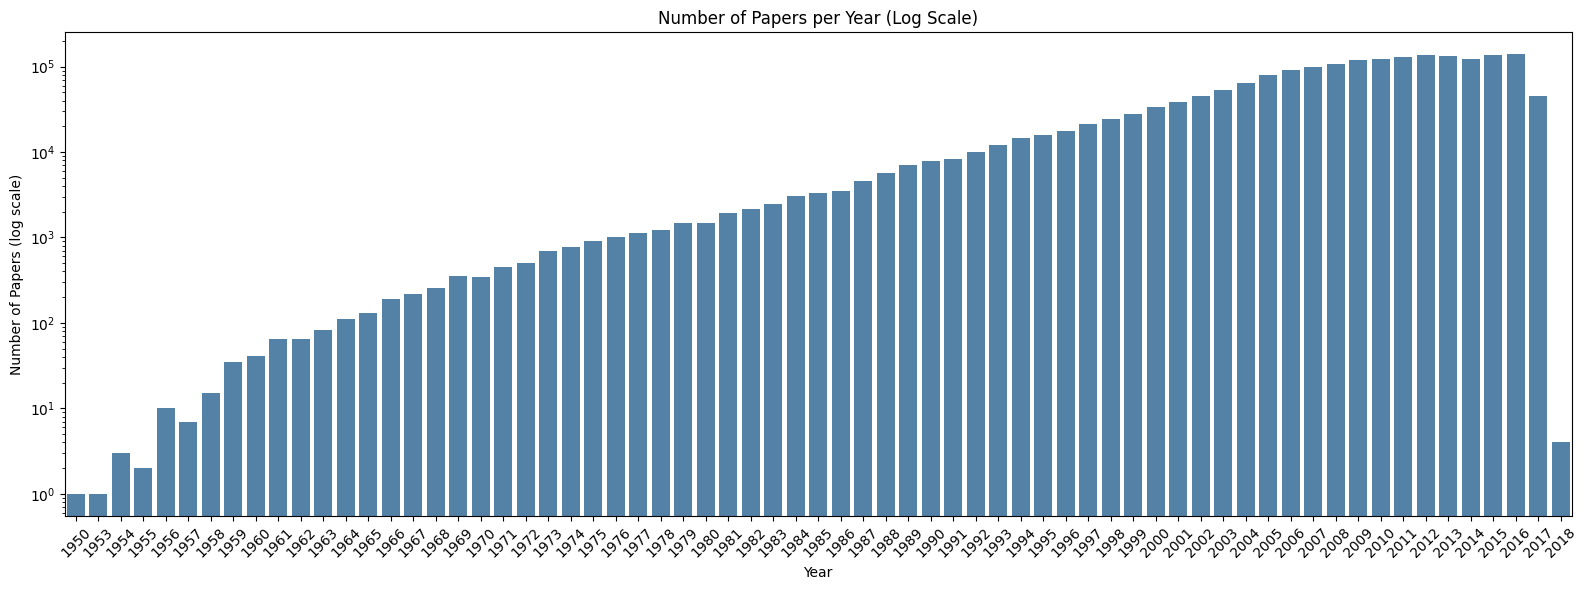

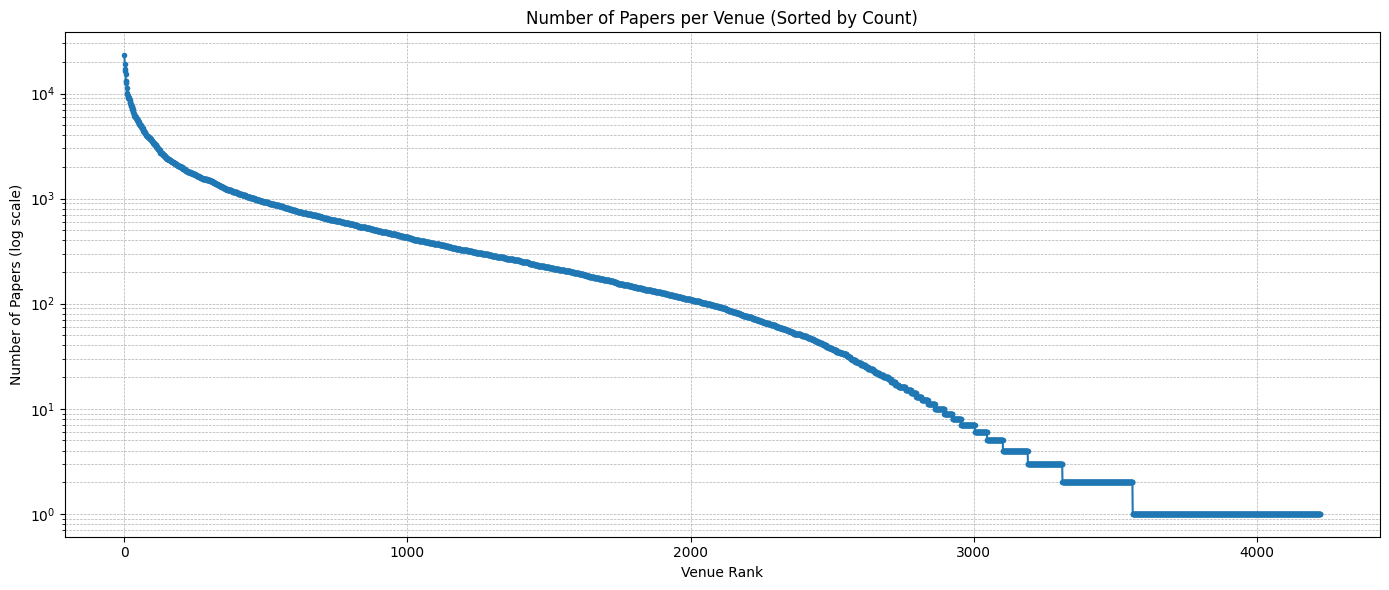

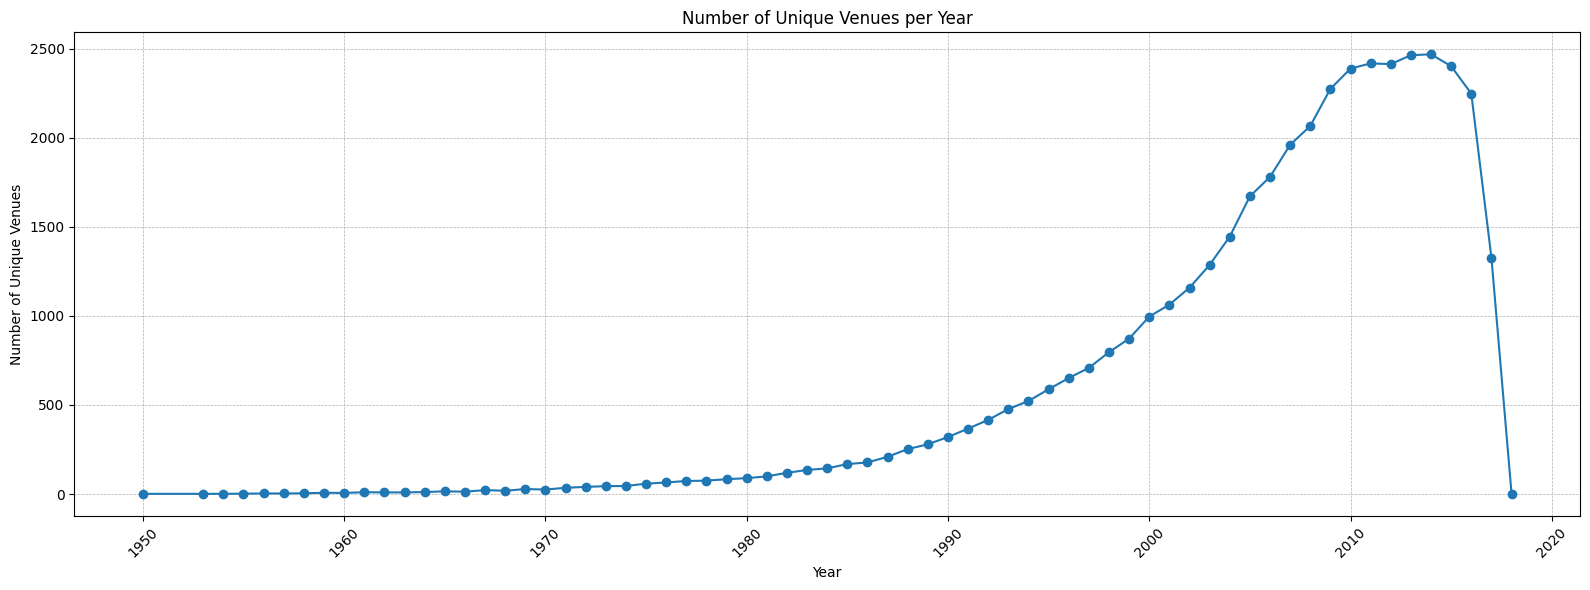

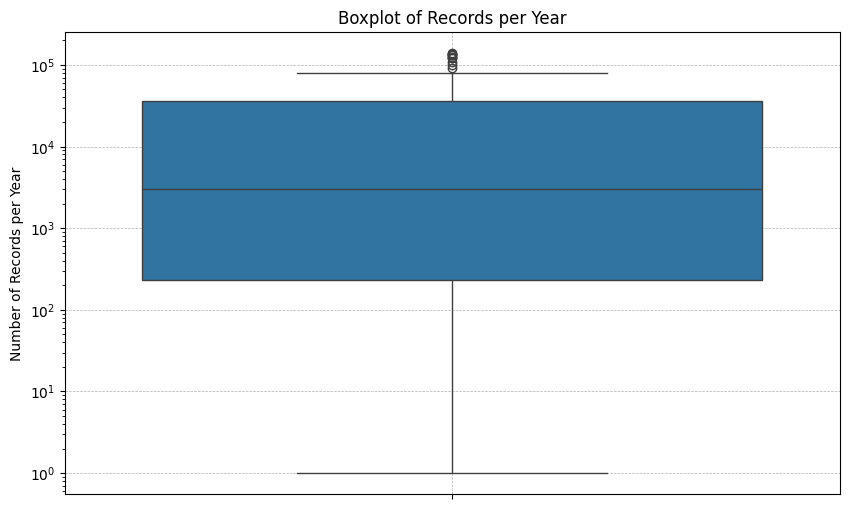

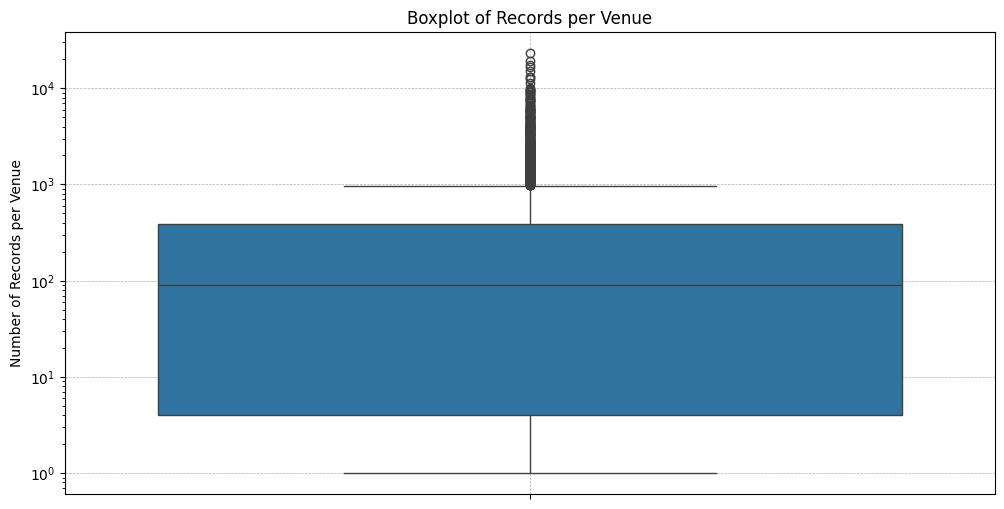

Venue count outliers: [1206, 1104, 1278, 1496, 2515, 1215, 1216, 1485, 9855, 1925, 1030, 5824, 7183, 1500, 7532, 1295, 1254, 1138, 2902, 1276, 2533, 1089, 4058, 2326, 1697, 3374, 1724, 1764, 2006, 2506, 1516, 1591, 1550, 2499, 3525, 3748, 1081, 1731, 2189, 3346, 1048, 1473, 1487, 1606, 1512, 4883, 7590, 1322, 2963, 1755, 1610, 3950, 1224, 1756, 1023, 1929, 2457, 2073, 8788, 9032, 2065, 2141, 3386, 1519, 1499, 5740, 1229, 1907, 1414, 2605, 1150, 1019, 1202, 4356, 3243, 1392, 1160, 1980, 4790, 3644, 2742, 2063, 2803, 7640, 3875, 5168, 2656, 2241, 1633, 6074, 5313, 6178, 1094, 1403, 9114, 3756, 1635, 2874, 2735, 1745, 1826, 3717, 3358, 4667, 1008, 1312, 9169, 1225, 2576, 5164, 3274, 2519, 5988, 1074, 2342, 2291, 1908, 1805, 2233, 2062, 1050, 1633, 1360, 1804, 4252, 1564, 6428, 1168, 1328, 2210, 1548, 1994, 1562, 1696, 2250, 1376, 1607, 1199, 1446, 1122, 2362, 1091, 1370, 1392, 1025, 1904, 1158, 3659, 1085, 2020, 4992, 2969, 1630, 1555, 1027, 1031, 1916, 1846, 1381, 1293, 1836, 1433, 1024,

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from collections import defaultdict

def read_jsonl_chunks(path, chunksize=100_000):
    """Read JSONL in memory-efficient chunks."""
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                yield pd.read_json(StringIO("[" + ",".join(batch) + "]"))
                batch = []
        if batch:
            yield pd.read_json(StringIO("[" + ",".join(batch) + "]"))

def inspect_cleaned_dataset(path):
    total_records = 0
    unique_venues = set()
    unique_years = set()
    year_counts = defaultdict(int)
    venue_counts = defaultdict(int)
    missing_abstracts = 0
    # New: venues per year
    venues_per_year = defaultdict(set)

    for chunk in read_jsonl_chunks(path):
        total_records += len(chunk)

        # Venues
        if "venue" in chunk:
            venues = chunk["venue"].dropna()
            unique_venues.update(venues.unique())
            for v in venues:
                venue_counts[v] += 1

        # Years
        if "year" in chunk:
            years = chunk["year"].dropna()
            unique_years.update(years.unique())
            for y in years:
                year_counts[y] += 1

        # Unique venues per year
        if "year" in chunk and "venue" in chunk:
            for y, v in zip(chunk["year"], chunk["venue"]):
                if pd.notna(y) and pd.notna(v):
                    venues_per_year[y].add(v)

    # Convert sets to counts for venues per year
    venues_count_per_year = {year: len(vs) for year, vs in venues_per_year.items()}

    return {
        "total_records": total_records,
        "unique_venues": sorted(unique_venues),
        "unique_years": sorted(unique_years),
        "year_counts": dict(sorted(year_counts.items())),
        "venue_counts": dict(sorted(venue_counts.items())),
        "venues_count_per_year": dict(sorted(venues_count_per_year.items()))
    }


# --------------------------------------------
# Usage
# --------------------------------------------
cleaned_file = "cleaned-dblp-combined.json"

stats = inspect_cleaned_dataset(cleaned_file)

print(f"Total records: {stats['total_records']}")
print(f"Unique venues: {len(stats['unique_venues'])}")
print(f"Unique years: {len(stats['unique_years'])}")
#print("Records per year:", stats['year_counts'])
#print("Records per venue (sample 20):", dict(list(stats['venue_counts'].items())[:20]))

# --------------------------------------------
# Records per year (log scale)
# --------------------------------------------
year_counts = stats['year_counts']

plt.figure(figsize=(16, 6))
sns.barplot(x=list(year_counts.keys()), y=list(year_counts.values()), color='steelblue')
plt.yscale('log')  # log scale for y-axis
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Number of Papers (log scale)")
plt.title("Number of Papers per Year (Log Scale)")
plt.tight_layout()
plt.show()

# --------------------------------------------
# Records per venue (log scale)
# --------------------------------------------

# Assume stats['venue_counts'] is a dict: {venue_name: count}
venue_counts = stats['venue_counts']

# Sort venues by count (descending)
sorted_counts = sorted(venue_counts.values(), reverse=True)

# x-axis: rank of the venue
ranks = np.arange(1, len(sorted_counts) + 1)

plt.figure(figsize=(14, 6))
plt.plot(ranks, sorted_counts, marker='o', linestyle='-', markersize=3)
plt.yscale('log')  # log scale for y-axis
plt.xlabel("Venue Rank")
plt.ylabel("Number of Papers (log scale)")
plt.title("Number of Papers per Venue (Sorted by Count)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# --------------------------------------------
# Venues per year (log scale)
# --------------------------------------------
plt.figure(figsize=(16, 6))
plt.plot(list(stats['venues_count_per_year'].keys()), 
         list(stats['venues_count_per_year'].values()), 
         marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Number of Unique Venues")
plt.title("Number of Unique Venues per Year")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Records per year
year_counts_list = list(stats['year_counts'].values())

plt.figure(figsize=(10, 6))
sns.boxplot(y=year_counts_list)
plt.yscale('log')  # Optional: log scale to handle skewed data
plt.ylabel("Number of Records per Year")
plt.title("Boxplot of Records per Year")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Records per venue
venue_counts_list = list(stats['venue_counts'].values())

plt.figure(figsize=(12, 6))
sns.boxplot(y=venue_counts_list)
plt.yscale('log')  # Optional: log scale to handle skewed data
plt.ylabel("Number of Records per Venue")
plt.title("Boxplot of Records per Venue")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

q1 = np.percentile(venue_counts_list, 25)
q3 = np.percentile(venue_counts_list, 75)
iqr = q3 - q1
outliers = [x for x in venue_counts_list if x < q1 - 1.5*iqr or x > q3 + 1.5*iqr]
print("Venue count outliers:", outliers)